In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import itertools
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler

# 1.ARIMA model

In [108]:
# data processing For ARIMA
raw_data = pd.read_csv('data/ABC_data.csv')
print(raw_data)
data_name = 'ABC'
attention_flag = False
train_len = 500
seq_length = 16
num_epochs = 100
# training and test set for ARIMA
ARIMA_Train = raw_data.loc[:,['close']][0:train_len]
ARIMA_Test =  raw_data.loc[:,['close']][train_len:]
ARIMA_Test_Input = raw_data.loc[:,['date']][train_len:]

            date   open    high      low  close   volume Name
0     2013-02-08  46.52  46.895  46.4600  46.89  1232802  ABC
1     2013-02-11  46.85  47.000  46.5000  46.76  1115888  ABC
2     2013-02-12  46.70  47.050  46.6000  46.96  1318773  ABC
3     2013-02-13  46.74  46.900  46.6000  46.64  2645247  ABC
4     2013-02-14  46.67  46.990  46.6000  46.77  1941879  ABC
...          ...    ...     ...      ...    ...      ...  ...
1254  2018-02-01  97.74  99.810  95.7300  99.29  2786798  ABC
1255  2018-02-02  99.09  99.090  95.9100  96.02  1660267  ABC
1256  2018-02-05  95.62  96.520  91.6900  91.90  2278534  ABC
1257  2018-02-06  92.58  93.370  86.9403  91.54  4574997  ABC
1258  2018-02-07  91.60  95.340  91.1000  94.22  2509484  ABC

[1259 rows x 7 columns]


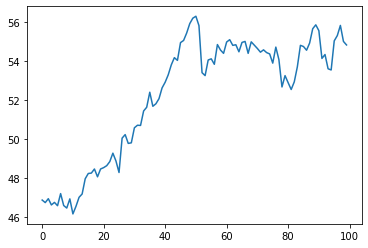

In [109]:
ARIMA_mean_log = np.log(raw_data.loc[:,['close']])
plt.plot(ARIMA_Train.iloc[:100])

In [110]:
# warnings.filterwarnings("ignore")
# q_arima = d_arima = range(0, 3)
# p_arima = range(0, 8)
# AIC_arima = []
# ARIMAX_model = []
# pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]

# for pdq in pdqs:
#     try:
#         mod = ARIMA(ARIMA_Train,order=pdq)

#         results = mod.fit()
#         print('ARIMAX{} - AIC:{}'.format(pdq, results.aic), end='\r')
#         AIC_arima.append(results.aic)
#         ARIMAX_model.append([(1,1,0), pdq])
#     except:
#             continue

In [111]:
# print('The smallest AIC is {} for model ARIMAX{}'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))
# order = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]

In [112]:
# sp500 (7,1,1)  ABC (7,1,2)  AAL(6,1,0)
order = (7,1,1)

In [113]:
# fit
model = ARIMA(ARIMA_Train, order)
fit = model.fit()

/usr/miniconda3/envs/nlu_cw2/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/miniconda3/envs/nlu_cw2/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and st

In [114]:
# fit.summary()

In [115]:
# predict 
preds = fit.predict(1,len(raw_data),typ='levels')
preds_pd = preds.to_frame()
preds_pd.index -= 1
print(preds_pd)

               0
0      46.987237
1      46.881590
2      47.047565
3      46.764615
4      46.862711
...          ...
1254  169.039996
1255  169.137233
1256  169.234470
1257  169.331706
1258  169.428943

[1259 rows x 1 columns]


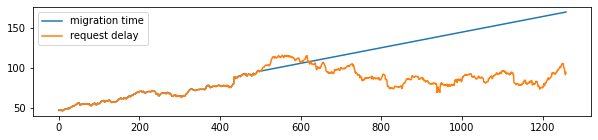

In [116]:
# draw predict figure
plt.figure(figsize=(10, 2))
plt.plot(preds_pd,label="migration time")
# plt.plot(ARIMA_Train.iloc[6600:6754],label="request delay")
plt.plot(raw_data.iloc[1:]["close"],label="request delay")
plt.legend()
plt.show()

In [117]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted', 'residuals'])
ARIMA_Result['raw'] = raw_data['close']
ARIMA_Result['predicted'] = preds_pd
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
# ARIMA_Result.to_csv('residual_result/{}_residual.csv'.format(data_name))
ARIMA_Result

,raw,predicted,residuals
0,46.89,46.987237,-0.097237
1,46.76,46.881590,-0.121590
2,46.96,47.047565,-0.087565
3,46.64,46.764615,-0.124615
4,46.77,46.862711,-0.092711
...,...,...,...
1254,99.29,169.039996,-69.749996
1255,96.02,169.137233,-73.117233
1256,91.90,169.234470,-77.334470
1257,91.54,169.331706,-77.791706


# LSTM structure

In [118]:
LSTM_data = pd.read_csv('residual_result/{}_residual.csv'.format(data_name))
ARIMA_close_prices = LSTM_data['residuals'][train_len:].values.astype(float)
#len(sp500_close_prices)

def create_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

#Data normalization
scaler = MinMaxScaler()
training_data = scaler.fit_transform(ARIMA_close_prices.reshape(-1,1))

x, y = create_sequences(training_data, seq_length)

train_size = int(0.8*train_len)
validate_size = int(0.2*train_len)   # set by hand

test_size = len(y) - train_size - validate_size
print(len(y))
print(test_size)

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

X_train = torch.Tensor(np.array(x[0:train_size]))
Y_train = torch.Tensor(np.array(y[0:train_size]))

training_dataset = TensorDataset(X_train,Y_train)
train_loader = DataLoader(training_dataset, num_workers=1, shuffle=True,batch_size = 64,drop_last = True)

X_validate = torch.Tensor(np.array(x[train_size:train_size+validate_size]))
Y_validate = torch.Tensor(np.array(y[train_size:train_size+validate_size]))

validate_dataset = TensorDataset(X_validate,Y_validate)
validate_loader = DataLoader(validate_dataset, num_workers=1, shuffle=True,batch_size = 64,drop_last = True)

X_test = torch.Tensor(np.array(x[train_size+validate_size:len(x)]))
Y_test = torch.Tensor(np.array(y[train_size+validate_size:len(y)]))
print(X_train[0],Y_train[0])
print(X_train[1],Y_train[1])

742
242
tensor([[0.8567],
        [0.8598],
        [0.8646],
        [0.8508],
        [0.8628],
        [0.8788],
        [0.8884],
        [0.8924],
        [0.8940],
        [0.8935],
        [0.8960],
        [0.9043],
        [0.9107],
        [0.9118],
        [0.9140],
        [0.9101]]) tensor([0.9071])
tensor([[0.8598],
        [0.8646],
        [0.8508],
        [0.8628],
        [0.8788],
        [0.8884],
        [0.8924],
        [0.8940],
        [0.8935],
        [0.8960],
        [0.9043],
        [0.9107],
        [0.9118],
        [0.9140],
        [0.9101],
        [0.9071]]) tensor([0.9094])


# Seq2Seq model

In [119]:
class simpleLSTM(nn.Module):

    def __init__(self, out_dims, input_dims, hidden_size, num_layers):
        super(simpleLSTM, self).__init__()
        
        self.out_dims = out_dims
        self.num_layers = num_layers
        self.input_dims = input_dims
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_dims, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, out_dims)

    def forward(self, x):
        hidden = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        cell = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (hidden, cell))
        
        h_out = h_out.view(-1, self.hidden_size)   
        
        prediction = self.fc(h_out)
        
        return prediction

class Seq2Seq_model(nn.Module):
    def __init__(self, n_class, hidden_size,num_layers):
        super(Seq2Seq_model, self).__init__()
        self.n_class = n_class
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.encoder = nn.LSTM(n_class, hidden_size,
                            num_layers)
        self.decoder = nn.LSTM(n_class, hidden_size,
                            num_layers)
        self.fc  = nn.Linear(hidden_size, n_class)
        
    def forward(self, enc_input, dec_input):
        
        #enc_input  [64, 8, 1] 
        
        _,(h_out,c_out) = self.encoder(enc_input)  # torch.Size([64, 8, 1])
        
        #dec_input [64, 1, 1]
        
        _, (decoder_h_out, _) = self.decoder(dec_input, (h_out,c_out))
        #print(outputs.size())
        decoded = self.fc(decoder_h_out)
        return decoded

class AttnDecoder(nn.Module):

    def __init__(self, code_hidden_size, hidden_size, time_step):
        super(AttnDecoder, self).__init__()
        self.code_hidden_size = code_hidden_size
        self.hidden_size = hidden_size
        self.T = time_step

        self.W = nn.Linear(in_features=2 * hidden_size, out_features=code_hidden_size)
        self.U = nn.Linear(in_features=code_hidden_size, out_features=code_hidden_size)
        self.tanh = nn.Tanh()
        self.V = nn.Linear(in_features=code_hidden_size, out_features=1)
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.tilde = nn.Linear(in_features=self.code_hidden_size + 1, out_features=1)
        self.fc1 = nn.Linear(in_features=code_hidden_size + hidden_size, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, encoder_output, y_seq, d , s):
        y_seq = y_seq.transpose(0,1)  #   1*64*1 -->64*1*1
        encoder_output = encoder_output.transpose(0,1)  # [8, 64, 16]->[64, 8, 16]

        # (seq_len, batch,  hidden_size):    
        batch_size = encoder_output.size(0)  
#         d = self.init_variable(1, batch_size, self.hidden_size)#. [1, 64, 16]
#         s = self.init_variable(1, batch_size, self.hidden_size)
        
        ct = self.init_variable(batch_size, self.hidden_size)    # [64, 16]
        
        for t in range(self.T):
            # batch_size * time_step * (encoder_hidden_size + decoder_hidden_size)
            # [time_step, 64, 16] ->[64 , tstep, 16] 
          
            h = encoder_output  # [64, 8, 16]
            d_s = torch.cat((self.embedding_hidden(d), self.embedding_hidden(s)), 2)    # [64 , 1, 16*2]
            z1 = self.W(d_s)  # [64 ,1, 16*2]-> [64 , 1, 16]
            z2 = self.U(h)  # [64, 8, 16]->[64, 8, 16]
            x = z1 + z2  # [64, 1, 16] + [64, 8, 16] = [64, 8, 16]
            z3 = self.V(self.tanh(x))   #   [64, 8, 16]->[64, 8, 1]

            beta_t = F.softmax(z3.view(batch_size, -1), dim=1)
            # yc 64*1*1
            # h [64, 8, 16]

            # [64, 1, 8] * [64, 8, 16] = [64, 1, 16] -> [64, 16]   batch_size * encoder_hidden_size
            ct = torch.bmm(beta_t.unsqueeze(1), h).squeeze(1)  # [64, 16]
            
            y_past = y_seq[:,t,:] # [64, 1]
            yc = torch.cat((y_past, ct), dim=1)  
            y_tilde = self.tilde(yc)
            _, states = self.lstm(y_tilde.unsqueeze(0), (d, s))    # [1, 64, 1]  [1, 64, 16]
            d = states[0]
            
        y_res = self.fc2(self.fc1(torch.cat((d.squeeze(0), ct), dim=1)))
        return y_res

    def init_variable(self, *args):
        zero_tensor = torch.zeros(args)
        if torch.cuda.is_available():
            zero_tensor = zero_tensor.cuda()
        return Variable(zero_tensor)

    def embedding_hidden(self, x):
        return x.repeat(self.T, 1, 1).permute(1, 0, 2)

    
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size,num_layers):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size,num_layers)
        
    def forward(self, x):

        
        # Propagate input through LSTM
      
        output, (hidden_out, cell_out) = self.lstm(x)
        
        return output, (hidden_out, cell_out)
    
    
class Decoder(nn.Module):
    
    def __init__(self, input_size, hidden_size,num_layers):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
  
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers)
        
        
    def forward(self,x,hidden,cell):
        
        
     
        output, (hidden_out, cell_out) = self.lstm(x, (hidden, cell))
        
        return output, (hidden_out, cell_out)

class Seq2Seq(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,out_dims,attention_flag = False):
        super().__init__()
        
        self.encoder = Encoder(input_size,hidden_size,num_layers)
        if attention_flag == True:
            self.decoder = AttnDecoder(hidden_size, hidden_size, 1)
        if attention_flag == False:
            self.decoder = Decoder(input_size,hidden_size,num_layers)

        self.fc = nn.Linear(hidden_size, out_dims)
        
        
    def forward(self, enc_input, dec_input):
        
        encoder_output,(h_out,c_out) = self.encoder(enc_input)  # torch.Size([64, 8, 1])

        #dec_input [64, 1, 1]     
        # h_out  [1, 64, 16]
        
        if attention_flag == True:
            y_res = self.decoder(encoder_output, dec_input,h_out,c_out)
        if attention_flag == False:
            _, (decoder_h_out, _) = self.decoder(dec_input,h_out,c_out)
            y_res = self.fc(decoder_h_out)

       
        return y_res

# Training

In [120]:
learning_rate = 0.005
input_dim = 1
hidden_size = 32
num_layers = 1
output_dim = 1
output_length = 1

model = Seq2Seq(input_dim,hidden_size,num_layers,output_dim,attention_flag)

#model = simpleLSTM(num_classes, input_size, hidden_size, num_layers)
# model = Seq2Seq_model(input_dim, hidden_size,num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [15]:
# Train the model
for epoch in range(num_epochs):
    for data in train_loader:
        X_train,Y_train = data
        Y_train = Y_train.unsqueeze(0)

        model.train()
        # decoder 的输入
        decoder_input = torch.zeros(64,1,1).transpose(0,1)

        #decoder_input = X_train[:,-1,:].unsqueeze(1)
        train_pred = model(X_train.transpose(0,1), decoder_input)
        
        # obtain the loss function
        train_loss = criterion(train_pred, Y_train)
        train_loss.backward(retain_graph=True) #backpropagation
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        for valdiate_data in validate_loader:
            X_validate,Y_validate = valdiate_data
            #decoder_input = X_validate[:,-1,:].unsqueeze(1)
            validate_pred =  model(X_validate.transpose(0,1),decoder_input)
            validate_loss = criterion(validate_pred,Y_validate)

    if epoch % 1 == 0:
        print("Epoch: %d, train_loss: %1.5f,validate_loss: %1.5f" % (epoch, train_loss,validate_loss))

/usr/miniconda3/envs/nlu_cw2/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 64, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, train_loss: 0.01284,validate_loss: 0.02603
Epoch: 1, train_loss: 0.00122,validate_loss: 0.00185
Epoch: 2, train_loss: 0.00030,validate_loss: 0.00038
Epoch: 3, train_loss: 0.00021,validate_loss: 0.00035
Epoch: 4, train_loss: 0.00021,validate_loss: 0.00042
Epoch: 5, train_loss: 0.00048,validate_loss: 0.00021
Epoch: 6, train_loss: 0.00042,validate_loss: 0.00023
Epoch: 7, train_loss: 0.00057,validate_loss: 0.00040
Epoch: 8, train_loss: 0.00030,validate_loss: 0.00021
Epoch: 9, train_loss: 0.00030,validate_loss: 0.00035
Epoch: 10, train_loss: 0.00020,validate_loss: 0.00017
Epoch: 11, train_loss: 0.00017,validate_loss: 0.00019
Epoch: 12, train_loss: 0.00017,validate_loss: 0.00014
Epoch: 13, train_loss: 0.00024,validate_loss: 0.00022
Epoch: 14, train_loss: 0.00019,validate_loss: 0.00014
Epoch: 15, train_loss: 0.00014,validate_loss: 0.00016
Epoch: 16, train_loss: 0.00027,validate_loss: 0.00014
Epoch: 17, train_loss: 0.00018,validate_loss: 0.00014
Epoch: 18, train_loss: 0.00012,validat

In [16]:
# save model
save_path = 'models/{}_lstm_model.zip'.format(data_name)
torch.save(model, save_path)

# Plot

742


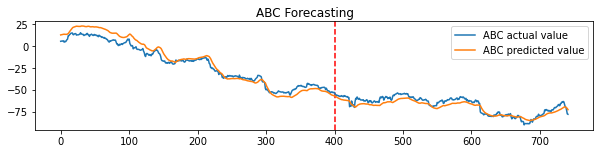

X_test MSE: 15.055584907531738
X_test MAE: 3.3361504077911377
X_test MAPE:5.022406950592995%
X_test RMSE: 3.880152702331543


In [121]:
# load model
save_path = 'models/{}_lstm_model.zip'.format(data_name)
model = torch.load(save_path)
model.eval()
train_predict = model(dataX.transpose(0,1),torch.zeros(1,dataX.size(0),1))
#print(train_predict.size(),dataY.size())
print(len(train_predict[0]))
train_predict = train_predict.squeeze(0)
data_predict = train_predict.data.numpy()

dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.figure(figsize=(10, 2))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label = data_name + ' ' + "actual value")
plt.plot(data_predict, label = data_name + ' ' + "predicted value")
plt.suptitle(data_name + ' ' + 'Forecasting')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):])   # 5500  
mae = mean_absolute_error(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):])
mape = mean_absolute_percentage_error(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):])*100
# rmsle = np.sqrt(mean_squared_log_error(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):]))
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print('X_test MAPE:{}%'.format(mape))
# print(f'X_test RMSLE: {rmsle}')
print(f'X_test RMSE: {rmse}')

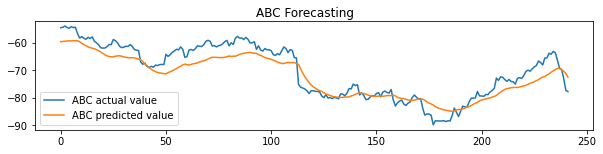

In [122]:
plt.figure(figsize=(10, 2))
plt.plot(dataY_plot[(train_size+validate_size):], label = data_name + ' ' + "actual value")
plt.plot(data_predict[(train_size+validate_size):], label = data_name + ' ' + "predicted value")
plt.suptitle(data_name + ' ' + 'Forecasting')
plt.legend()
plt.show()

In [123]:
result_start = train_len+seq_length+1
final_result = ARIMA_Result['predicted'].loc[result_start:].values + data_predict.squeeze(1)

/usr/miniconda3/envs/nlu_cw2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


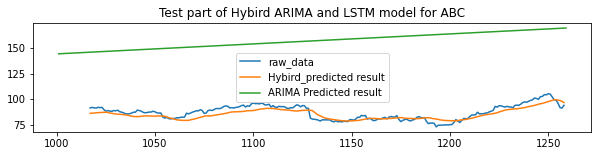

In [124]:
df  = ARIMA_Test[result_start:]
df['hybrid_result'] = final_result[train_len:]
plt.figure(figsize=(10, 2))
plt.title("Test part of Hybird ARIMA and LSTM model for {}".format(data_name))
df['close'].plot(x_compat=True, label = 'raw_data')
plt.plot(df['hybrid_result'], label = 'Hybird_predicted result')
plt.plot(preds[2*train_len:], label = "ARIMA Predicted result")
plt.legend()
plt.show()

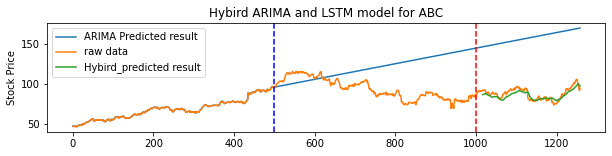

In [125]:
plt.figure(figsize=(10, 2))
plt.title("Hybird ARIMA and LSTM model for {}".format(data_name))
plt.plot(preds_pd,label="ARIMA Predicted result")
plt.plot(raw_data.iloc[1:]["close"],label="raw data")
plt.plot(df['hybrid_result'], label = 'Hybird_predicted result')
plt.axvline(x=2*train_len, c='r', linestyle='--')
plt.axvline(x=train_len, c='b', linestyle='--')
plt.ylabel("Stock Price")
plt.legend()
plt.show()